# Multi-scale Low Rank Decomposition Demo

## Introduction

Multi-scale signal transforms are commonplace in signal analysis, engineering. Commonly known examples include wavelet pyramids, and discrete cosine transform, used for image compression. The utility of such representations lies in their ability to **compactly represent natural signals**. MRI Imaging also takes advantage of this property. 

![mslrd2.png](mslrd2.png "Illutration of Multi-scale Representation")

Similarly, low rank models provide a means for **subspace estimation**. Recall that a matrix is low-rank when it can be expressed by a (relatively) small number of basis vectors. 
Essentially, a low rank matrix possesses **redundancy**. This proves useful in tasks that are essentially matrix completion problems. 
If you can say with reasonable confidence that your target data with 'holes' or unknown values is low rank, then low-rank models can help estimate them reliably and often quite accurately. 

In the paper *Beyond Low Rank + Sparse: Multi-scale Low Rank Matrix Decomposition* [1], the authors introduce a matrix decomposition method that capitalizes on multi-scale structures and low rank methods.

### Why combine the two?

The argument for utilizing multi-scale representation in conjunuction with low rank modeling is quite simple. Signals often exhibit multi-scale structure. Therefore, you can capture correlation at more than one scale, and represent it more compactly, with more granularity than a low rank model for the whole signal. The paper proposes modeling the target data matrix as a sum of block matrices of increasing sizes, with each set of blocks of equal size comprising a scale. 


## An illustration of low rank data

In [1]:
import numpy as np
from multiprocessing import Pool
import numpy.matlib as npm
import matplotlib.pyplot as plt
import cv2
from blockSVT import blockSVT
from liveplot import liveplot
from skimage.transform import resize
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error
from randshift import *
from gen_hanning import gen_hanning
from sklearn.preprocessing import normalize

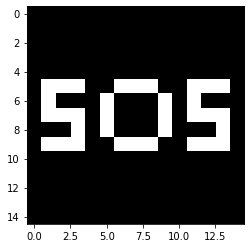

In [2]:
sos = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0],
          [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
          [0, 1, 1, 1, 0, 1, 0, 0 ,0, 1, 0, 1, 1, 1, 0],
          [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
          [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
plt.imshow(sos, cmap='gray')

This very simple image has $9$ rows, of which only $5$ are populated, so the rank will not exceed $5$. Let's plot the singular values of this image.

(Text(0.5, 0, 'component'), Text(0, 0.5, 'Singular Value'))

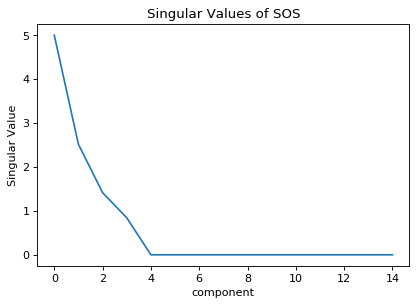

In [3]:
ua, sa, va = np.linalg.svd(sos)
plt.figure(figsize=(6, 4), dpi= 80), plt.plot(range(sos.shape[0]), sa.tolist())
plt.title('Singular Values of SOS')
plt.xlabel('component'), plt.ylabel('Singular Value')

How well can the image be represented if we retain only 3 or 4 of these singular values? 

(<matplotlib.image.AxesImage at 0x7f7409ab1e48>, Text(0.5, 1.0, 'Top-4'))

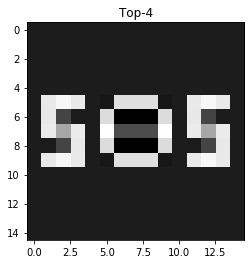

In [4]:
# Keep k=3
sos2 = np.matmul(np.matmul(ua[:,0:3], np.diag(sa[0:3])), va[0:3, :])
plt.imshow(sos2, cmap='gray'), plt.title('Top-4')

(<matplotlib.image.AxesImage at 0x7f7409a21588>, Text(0.5, 1.0, 'Top-3'))

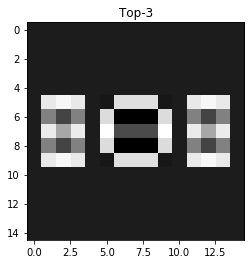

In [5]:
# Keep 2
sos2 = np.matmul(np.matmul(ua[:,0:2], np.diag(sa[0:2])), va[0:2, :])
plt.imshow(sos2, cmap='gray'), plt.title('Top-3')

### What does this mean?
Low rank approximation with the top 4 singular values returns a fairly reasonable recovery of the original image, but crucially, with fewer meaningful values than the original. Beyond a point of course, lower and lower rank approximations will render the recovery unrecognizable from the original image. One utlility of this property is that you could use low rank approximations to recover an image corrupted by noise. 

## Creating Synthetic Images using window functions

We're going to generate artificial frames using an appropriate window function to simulate low rank structures. In each case, the basis vector of the structures will be defined using increasing widths of Hanning windows. Summing these frames and creating a single image will simulate multi-scale structure.

One can choose to generate an image $Y$ of size $N \times N$, composed of $L$ scales. Each scale is created using a basis vector generated from a Hanning window of width $w_{Hann}$. The low rank structures in each scale are embedded in the respective frame $Y_i$ randomly. 

$$
Y = \sum_{i=1}^L Y_{i}
$$

In [6]:
N = 64
L = np.log2(N)
FOV = (N, N)
max_L = L
block_sizes = 2**np.arange(0, int(max_L+1),2)
ms = block_sizes
ns = ms
block_sizes = [(x, x) for x in block_sizes]

print("Block sizes: ", block_sizes)

Block sizes:  [(1, 1), (4, 4), (16, 16), (64, 64)]


In this example we're defining the image size to be $64 \times 64$, composed of 4 scales. Choosing an arbitrary  but increasing window width for each scale, we generate the following multi-scale image.

In [7]:
nblocks = np.array([10, 6, 4, 1])
border = np.ones((64, 5))
X, X_decom = gen_hanning(FOV, block_sizes, nblocks, 0)
X_d = np.concatenate([X, border, X_decom[:,:,0], border, X_decom[:,:,1], border, X_decom[:,:,2], border, X_decom[:,:,3]], axis=1)

Text(0.5, 1.0, 'Synthetic image using random Hanning basis vectors with indvidual scales')

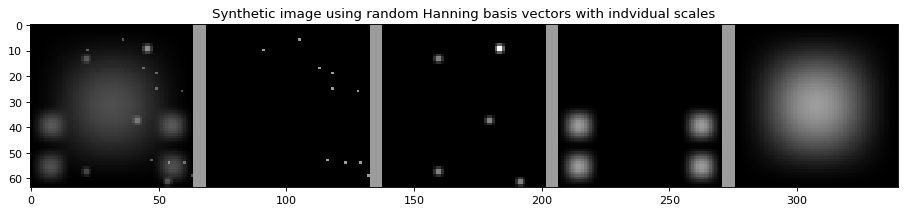

In [8]:
plt.figure(figsize=(14, 12), dpi= 80)
plt.imshow(np.abs(X_d), cmap='gray')
plt.title('Synthetic image using random Hanning basis vectors with indvidual scales')

### Verifying the low-rank nature of each scale

By visualizing the singular values for each frame, we can verify their low-rank nature. 

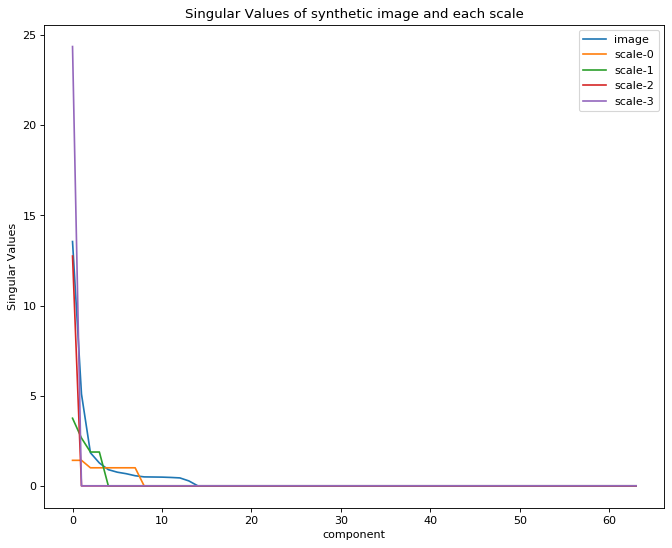

In [9]:
_, sx, _ = np.linalg.svd(X)
_, sx0, _ = np.linalg.svd(X_decom[:,:,0])
_, sx1, _ = np.linalg.svd(X_decom[:,:,1])
_, sx2, _ = np.linalg.svd(X_decom[:,:,2])
_, sx3, _ = np.linalg.svd(X_decom[:,:,3])
plt.figure(figsize=(10, 8), dpi= 80)
plt.plot(range(X.shape[0]), sx.tolist(), label='image')
plt.plot(range(X.shape[0]), sx0.tolist(), label='scale-0')
plt.plot(range(X.shape[0]), sx1.tolist(), label='scale-1')
plt.plot(range(X.shape[0]), sx2.tolist(), label='scale-2')
plt.plot(range(X.shape[0]), sx3.tolist(), label='scale-3')
plt.title('Singular Values of synthetic image and each scale')
plt.xlabel('component'), plt.ylabel('Singular Values')
plt.legend(loc="upper right")

Note that the $0^{th}$ scale that was created using the shortest basis vector exhibits the strong sparsity compared to the next two scales, while the last i.e. $3^{rd}$ scale has the lowest rank of all. 

This indicates that images which exhibit similar properties can be decomposed at least in a Sparse+Low Rank fashion. If there is a sufficient difference of resolution between the low rank structures in the image, then  multi-scale decomposition is possible.

As an additional experiment, let's look at how the image $Y$ is separable as only the sparsest and low rank component, which we will establish before demonstrating multi-scale low rank decomposition.

(<matplotlib.image.AxesImage at 0x7f74098d3320>,
 Text(0.5, 1.0, 'True Sparse + Low Rank Separation of Y'))

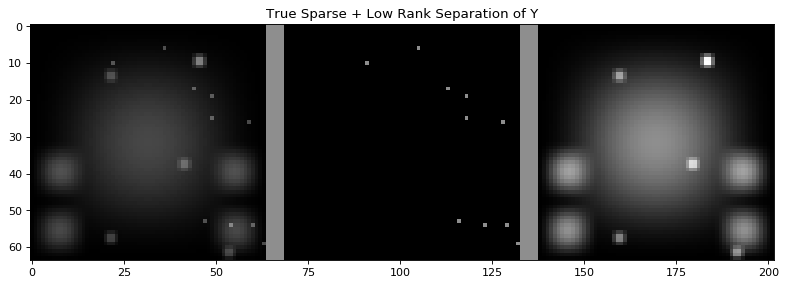

In [10]:
Sy = X_decom[:,:,0]
Ly = X_decom[:,:,1] + X_decom[:,:,2] + X_decom[:,:,3]
YSL = np.concatenate([X, border, Sy, border, Ly], axis=1)
plt.figure(figsize=(12, 10), dpi= 80)
plt.imshow(YSL, cmap='gray'), plt.title('True Sparse + Low Rank Separation of Y')

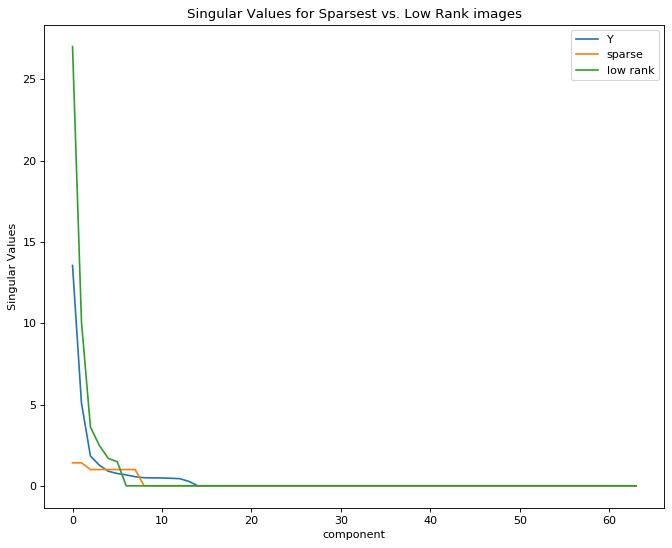

In [11]:
_, ss, _ = np.linalg.svd(Sy)
_, sl, _ = np.linalg.svd(Ly)
plt.figure(figsize=(10, 8), dpi= 80)
plt.plot(range(X.shape[0]), sx.tolist(), label='Y')
plt.plot(range(X.shape[0]), ss.tolist(), label='sparse')
plt.plot(range(X.shape[0]), sl.tolist(), label='low rank')
plt.title('Singular Values for Sparsest vs. Low Rank images')
plt.xlabel('component'), plt.ylabel('Singular Values')
plt.legend(loc="upper right")

As expected, the low rank component of the image $Y$ is anything but sparse. At this point this observation may seem contrived, since the image in question is deliberately generated, but is necessary to establish for the next topic of discussion.

## Low Rank + Sparse Recovery using Robust PCA

We will now run some experiments to see how well the Sparse and Low rank componenets of the artificial image can be separated. For this, we use Robust Principal Component Analysis [2].

Using notations from the paper by Candes et. al, the problem is defined as the decomposition of a large data matrix $M$ as follows:
$$
M = L_0 + S_0
$$

To recover $L_0$ and $S_0$ as accurately as possible, the minimization problem is formulated as:

$$
\DeclareMathOperator*{\minimize}{minimize}
\minimize ||L||_{nuc} + \lambda||S||_1,
$$

$$
\DeclareMathOperator*{\st}{subject to}
\st L + S = M,
$$

where $||\cdot||_{nuc}$ is the nuclear norm

As the paper [2] notes, this kind of separation makes sense only when the low rank component of this proposed separation is not sparse. Which as we have already demonstrated, is dictated by the singular value vector of the expected low-rank component. 

The code cells below demonstrate how RPCA can yield separation of this nature. The code for RPCA is derived from [3]

In [12]:
from r_pca import *

rpca = R_pca(X)
L, S = rpca.fit(max_iter=10000, iter_print=100)

iteration: 1, error: 0.028412215962960185
iteration: 100, error: 8.08046140828942e-05
iteration: 200, error: 6.189817973155816e-05
iteration: 300, error: 5.437930875493416e-06
iteration: 348, error: 2.0012656256858156e-07


Text(0.5, 1.0, 'Sparse and Low Rank forms from RPCA')

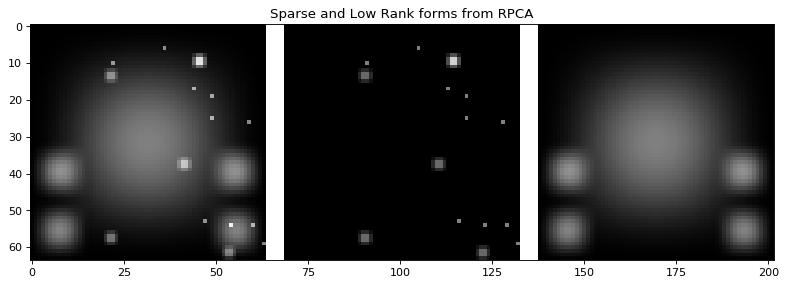

In [13]:
XSL = np.concatenate([X, border, S, border, L], axis=1)
plt.figure(figsize=(12, 10), dpi= 80), plt.imshow(XSL, cmap='gray')
plt.title('Sparse and Low Rank forms from RPCA')

**Observations:** We see that the lowest rank structures manifest in the sparse matrix, while the structures larger structures present in the low rank matrix. Compared to the true sparsest scale, $L_y$ here contains structures of two different scales, unlike the separation we plotted initially. Since the difference in their ranks is rather small, they occur together in $L_y$. 

## Motivation for Multi-scale Low Rank Decomposition

The above experiment gives us a concrete motivation for multi-scale low rank decomposition. To correctly separate low rank structures across multiple scales, without overlap between structures of similar rank can be achieved using the algorithm proposed by Ong et. al in [1]. A key advantage of the method is that we have direct control over the granularity of the decomposition. The rank of for each multi-scale structure can be chosen prior to decomposition to ensure they can be separated correctly. 

The key assumption to be made before proceeding with multi-scale decomposition is that the candidate image should exhibit low rank structures of differing ranks. 


### Formulation

The problem formulation in brief is outlined below.
Given an image $Y$, we want to decompose it as:
$$
Y = \sum_{i=1}^L X_i
$$

where $L$ are the number of scales that might constitute the image. 

![bloc_operator.png](bloc_operator.png "Block extraction")

The key to modeling multi-scale structure is to represent the image as the combination of blocks of increasing size, as shown above. 

If the block extraction operation can be written as $R_b(X_i)$, then we can formulate the problem as the minimization of block-wise rank for each block, with the condition that the integrity of $Y$ holds. This can be written as:

$$
\DeclareMathOperator*{\minimize}{minimize}
\DeclareMathOperator*{\rank}{rank}
\minimize \sum_{i=1}^L \sum_{b \in P_i} \rank(R_b(X_i))
$$

$$
\DeclareMathOperator*{\st}{subject to}
\st Y = \sum_{i=1}^L X_i
$$

There are 2 problems with this formulation. 

1. Each rank minimization will add to problem complexity in a combinatorial fashion.
2. Not obvious whether direct summation of ranks is the correct formulation. 

The first point makes this an NP-hard problem to solve. 

The second point is intuitive, because the cost of computation for a 1-sparse matrix and a rank-1 matrix will  not be equal. 

### Convex Relaxation

Minimizing the rank can be done  by minimizing the nuclear norm. Consequently, it becomes necessary to define how the nuclear norm is computed in the block-wise model that was established earlier. 

The block-wise nuclear norm $||\cdot||_{(i)}$ is defined as a function of the nuclear norm $||\cdot||_{nuc}$
$$
||\cdot||_{(i)} = \sum_{b \in P_i} ||R_b(\cdot)||_{nuc}
$$

Having established that, the convex relaxation for the minimization problem is:

$$
    \minimize_{X_1, X_2 . . . X_L} \sum_{i=1}^L \lambda_i ||X_i||_{(i)}
$$
$$ \st Y = \sum_{i=1}^L X_i$$

## Multi-scale decomposition as a generalization of L+S Decomposition

The relaxation above looks similar to the L+S problem we experimented with in the previous section. Turns out, L+S decomposition is a special case of the more generalized formulation of multi-scale low rank decomposition. 

$$
\minimize_{X_1, X_2 . . . X_L} \sum_{i=1}^L \lambda_i ||X_i||_{(i)}
$$

Can be rewritten as 
$$
\minimize_{X_1, X_2 . . . X_L} \lambda_1||X_1||_1 + \sum_{i=2}^L ||X_i||_{(i)}
$$

The first term is simplified since the nuclear norm applied to any $1 \times 1$ block will be equivalent to taking the $l_1$ norm. 

If we wished to obtain an aggregated low-rank image instead of multiple scales, then the second term can be simplified to the minimization of a single matrix $L$, which would be the aggregation of the remaining scales $X_i$. As a result, the problem reduces to the form discussed in Robust PCA [2], which was:

$$
\DeclareMathOperator*{\minimize}{minimize}
\minimize \lambda||S||_1 + ||L||_{nuc}
$$

$$
\DeclareMathOperator*{\st}{subject to}
\st L + S = Y,
$$

where $L = \sum_{i=2}^L X_i$ and $S = X_1$

The solver used for this problem is ADMM. By dividing the optimization problem into two separable objectives, both of which are connected by an equality condition. 

## Multi-scale Decomposition on the Hanning image

### Defining regularization parameters for each scale

In [14]:
nIter = 50
rho = 10

levels = len(block_sizes)
bs = np.prod(np.divide(npm.repmat(FOV, levels, 1), block_sizes), 1).astype(np.int)
lambdas = np.sqrt(ms) + np.sqrt(ns) + np.sqrt(np.log2(np.multiply(bs, np.minimum(ms, ns))))

print(lambdas)

[ 5.46410162  7.16227766 10.82842712 18.44948974]


In [15]:
FOVl = FOV + (levels,)
level_dim = len(FOV)

A = lambda x : np.sum(x, level_dim) # Summation
AT = lambda x : np.repeat(x[:,:,np.newaxis], levels, axis=2) # Adjoint Operator

X_it = np.zeros(FOVl)
Z_it = np.zeros(FOVl)
U_it = np.zeros(FOVl)

### Using Parallel Pooling to speed up decomposition

Since block-wise Singular Value Thresholding must be run on each block for every scale, the algorithm can be rather slow for increasing image sizes and more scales. 

In [16]:
# Function passed to mp.Pool instance
def parSVT(l):
    """
    """
    XU = np.transpose((X_it+U_it), (2, 0, 1))
    XU_s, r = randshift(XU)
    out = blockSVT((XU[l,:,:]), block_sizes[l], (lambdas[l] / rho))
    XU = randunshift(out, r)
    return out

In [17]:
# Define the maximum number of pools allowed
# contingent on the number of scales for decomposition
# and available system resources

numpools = levels if levels<=10 else 10

In [18]:
for it in range(nIter):
        X_it = 1 / levels * AT(X - A(Z_it - U_it)) + Z_it - U_it
        with Pool(processes=numpools) as pool:
            data = pool.map(parSVT, range(levels))
            pool.close()
            pool.terminate()
            pool.join()
        Z_it = np.reshape(np.asarray(data), (levels, N, N))
        Z_it = np.transpose(Z_it, (1, 2, 0))
        U_it = U_it - Z_it + X_it

(<matplotlib.image.AxesImage at 0x7f7445467828>,
 Text(0.5, 1.0, 'Decomposition over 4 scales'))

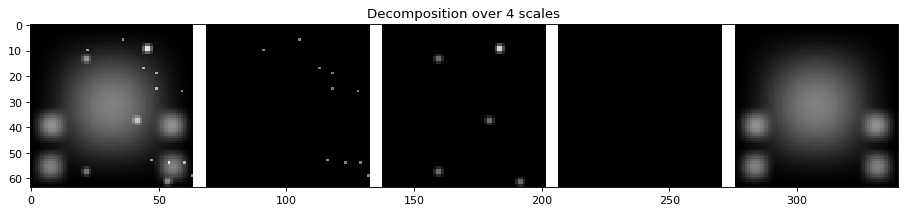

In [19]:
X_new = np.concatenate([X, border, X_it[:,:,0], border, X_it[:,:,1], border, X_it[:,:,2], border, X_it[:,:,3]], axis=1)
plt.figure(figsize=(14, 12), dpi= 80)
plt.imshow(np.abs(X_new), cmap="gray"), plt.title('Decomposition over 4 scales')

Let's look at the true decomposition for comparison.

Text(0.5, 1.0, 'True Decomposition')

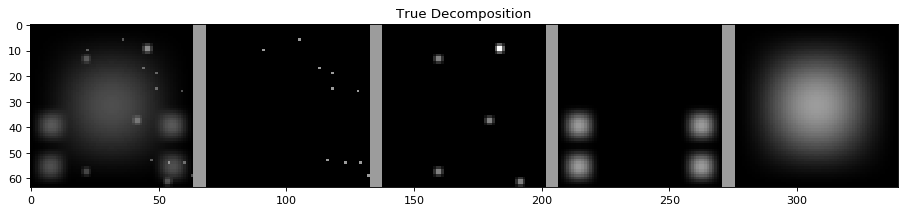

In [20]:
plt.figure(figsize=(14, 12), dpi= 80)
plt.imshow(np.abs(X_d), cmap='gray')
plt.title('True Decomposition')

### Overall error

Using mean squared error we can evaluate the error in decomposition compared to the true decomoposition.

In [21]:
# MSE for scale-0
S0 = mean_squared_error(normalize(np.abs(X_decom[:,:,0])),normalize(np.abs(X_it[:,:,0])))
print(S0)

0.01342773479685306


In [22]:
# MSE for scale-1
S1 = mean_squared_error(normalize(np.abs(X_decom[:,:,1])),normalize(np.abs(X_it[:,:,1])))
print(S1)

0.010742190561205171


In [23]:
# MSE for scale-2
S2 = mean_squared_error(normalize(np.abs(X_decom[:,:,2])),normalize(np.abs(X_it[:,:,2])))
print(S2)

0.01759088074194937


In [24]:
# MSE for scale-3
S3 = mean_squared_error(normalize(np.abs(X_decom[:,:,3])),normalize(np.abs(X_it[:,:,3])))
print(S3)

0.004625426312083579


**Observation:** The MSE for the largest low-rank scale is smallest, which is expected since there's not much complexity in this scale. Similarly, the sparsest scale shows the least MSE since the minimization in this scale reduces to $l_1$.

### Tracking Performance

In [25]:
S0_psnr = [0]*50
S1_psnr = [0]*50
S2_psnr = [0]*50
S3_psnr = [0]*50

In [26]:
print('Generating synthetic image')
X, X_decom = gen_hanning(FOV, block_sizes, nblocks, 10)
X_it = np.zeros(FOVl)
Z_it = np.zeros(FOVl)
U_it = np.zeros(FOVl)
print('Computing Decomposition...')
for it in range(nIter):
    X_it = 1 / levels * AT(X - A(Z_it - U_it)) + Z_it - U_it
    with Pool(processes=numpools) as pool:
        data = pool.map(parSVT, range(levels))
        pool.close()
        pool.terminate()
        pool.join()
    Z_it = np.reshape(np.asarray(data), (levels, N, N))
    Z_it = np.transpose(Z_it, (1, 2, 0))
    U_it = U_it - Z_it + X_it

    S0_psnr[it] = mean_squared_error(
                                        normalize(np.abs(X_decom[:,:,0])),
                                        normalize(np.abs(X_it[:,:,0])))
    S1_psnr[it] = mean_squared_error(
                                        normalize(np.abs(X_decom[:,:,1])),
                                        normalize(np.abs(X_it[:,:,1])))
    S2_psnr[it] = mean_squared_error(
                                        normalize(np.abs(X_decom[:,:,2])),
                                        normalize(np.abs(X_it[:,:,2])))
    S3_psnr[it] = mean_squared_error(
                                        normalize(np.abs(X_decom[:,:,3])),
                                        normalize(np.abs(X_it[:,:,3])))


Generating synthetic image
Computing Decomposition...


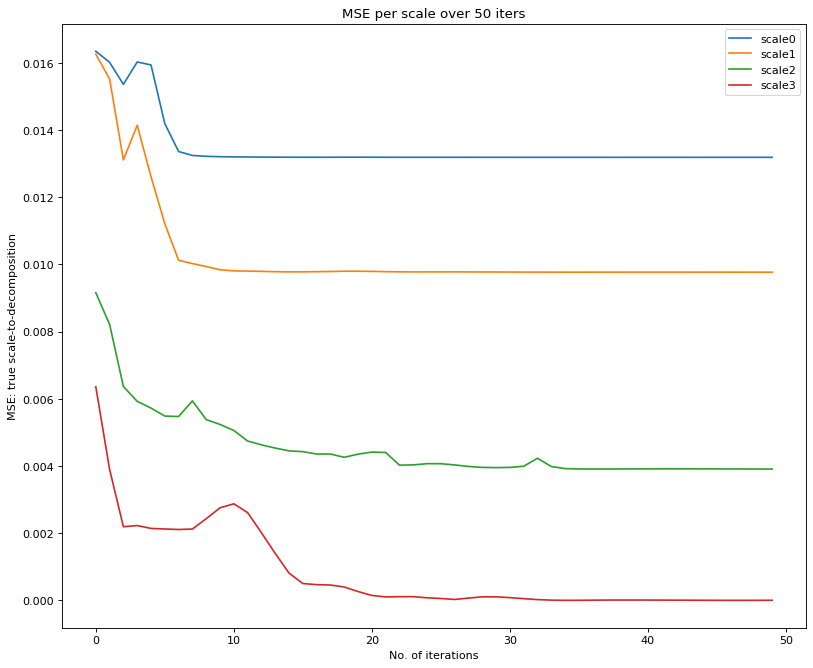

In [27]:
iters = range(0, 50)

plt.figure(figsize=(12, 10), dpi= 80)
plt.plot(iters, S0_psnr), plt.plot(iters, S1_psnr)
plt.plot(iters, S2_psnr), plt.plot(iters, S3_psnr)
plt.legend(["scale0", "scale1", "scale2", "scale3"])
plt.xlabel('No. of iterations')
plt.ylabel('MSE: true scale-to-decomposition')
plt.title('MSE per scale over 50 iters')
plt.show()


## A Practical Application

In the paper, the authors explore lesion and background separation in Dynamic Contrast Enhanced MRI (DCE-MRI) image sequences. The reasoning here is that different tissues will exhibit changing contrast over time as the dye circulates in the patient, which can be isolated using low rank modeling. 

The impact of using multi-scale low rank decomposition on image sequences and videos is easier to appreciate due to the temporal variation in structural contrast of some tissues against the rest. 

However, the possibility of lesion isolation is an interesting possibility we wanted to explore.

### Lesion isolation in retinal fundus images

![idrid_11.png](idrid_11.png "Retinal image with lesions")


The original image is of a rather high resolution, so for a preliminary test, it can be resampled to a size of $(256\times 256)$. Of course, for any meaningful extraction of features such a severe reduction in resolution leads to a lot of lost data. For the sake of testing though, it will have to do. 

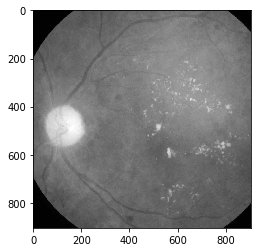

In [28]:
I = cv2.imread('./idrid_11.png')[:,:,2]
plt.imshow(I, cmap='gray')

In [29]:
X = resize(I, (256, 256))

N = 256             # Size of square input
L = np.log2(N)      # No. of scales
FOV = (N, N)        # Shape of input

nIter = 200        # No. of iterations for ADMM

rho = 10            # ADMM param

max_L = L

block_sizes = 2**np.arange(0, int(max_L+1),2)       # block sizes
ms = block_sizes
ns = ms
block_sizes = [(x, x) for x in block_sizes]

print("Block sizes: ", block_sizes)

levels = len(block_sizes)

bs = np.prod(np.divide(npm.repmat(FOV, levels, 1), block_sizes), 1).astype(np.int)
print("bs is: ", bs)
lambdas = np.sqrt(ms) + np.sqrt(ns) + np.sqrt(np.log2(np.multiply(bs, np.minimum(ms, ns))))

Block sizes:  [(1, 1), (4, 4), (16, 16), (64, 64), (256, 256)]
bs is:  [65536  4096   256    16     1]


In [30]:
FOVl = FOV + (levels,)

level_dim = len(FOV)
#plt.imshow(X), plt.show()

A = lambda x : np.sum(x, level_dim) # Summation

AT = lambda x : np.repeat(x[:,:,np.newaxis], levels, axis=2) # Adjoint Operator

X_it = np.zeros(FOVl)
Z_it = np.zeros(FOVl)
U_it = np.zeros(FOVl)


In [31]:
for it in range(nIter):
        X_it = 1 / levels * AT(X - A(Z_it - U_it)) + Z_it - U_it
        with Pool(processes=numpools) as pool:
            data = pool.map(parSVT, range(levels))
            pool.close()
            pool.terminate()
            pool.join()
        Z_it = np.reshape(np.asarray(data), (levels, N, N))
        Z_it = np.transpose(Z_it, (1, 2, 0))
        U_it = U_it - Z_it + X_it

(<matplotlib.image.AxesImage at 0x7f74453a89e8>,
 Text(0.5, 1.0, 'Original, scale-0 and scale-1'))

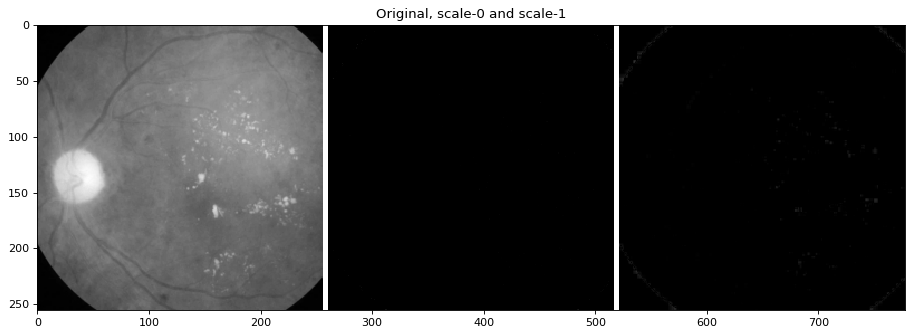

In [32]:
border = np.ones((256, 5))

I_d1 = np.concatenate([X, border, X_it[:,:,0], border, X_it[:,:,1]], axis=1)
plt.figure(figsize=(14, 12), dpi= 80)
plt.imshow(np.abs(I_d1), cmap="gray"), plt.title('Original, scale-0 and scale-1')

(<matplotlib.image.AxesImage at 0x7f74452fc438>,
 Text(0.5, 1.0, 'Original, scale-2 and scale-3'))

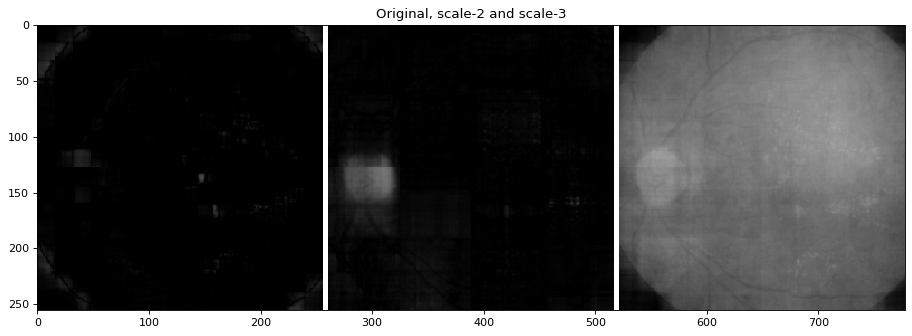

In [33]:
I_d2 = np.concatenate([X_it[:,:,2], border, X_it[:,:,3], border, X_it[:,:,4]], axis=1)
plt.figure(figsize=(14, 12), dpi= 80)
plt.imshow(np.abs(I_d2), cmap="gray"), plt.title('Original, scale-2 and scale-3')

As can be seen, some of the higher intensity lesion spots show up in the $3^{rd}$ scale. Similarly, the optic nerve head (which is the circular disc in the image) counts as a low rank structure for block-size of $64 \times 64$. Finally, the retinal background remains in the final low-rank scale, but the lesions and the nerve head are understated, since they have been 'filtered' through iterative thresholding into the respective scales defined by the their structural geometry.

## Can the lesions be isolated with greater fidelity?

I suspect that treating the original high resolution image as several sub-images and decomposing those individually should provide a better separation of features than the example in the previous section. However, the success of this will depend on whether 

In [34]:
I.shape

(904, 904)

## References



[1] F. Ong and M. Lustig, “Beyond low rank + sparse: Multi-scale low rank matrix decomposition,” 2016 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), Mar. 2016.

[2] E. Candes, X. Li, Y. Ma, and J. Wright, “Robust principal component analysis?: Recovering low-rank matrices from sparse errors,” 2010 IEEE Sensor Array and Multichannel Signal Processing Workshop, Oct. 2010.

[3] D. Ganguli, O. Botvinnik, "Robust-PCA," [Github repository](https://github.com/dganguli/robust-pca)